In [154]:
# common imports
import numpy as np
import pandas as pd
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports


# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.
>

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [155]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [156]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [157]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [158]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [159]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [160]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [161]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Frame number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The strength of a grab hand pose (values in range [0,1])
** Grab strength deprecated from version 2.0, use grab angle instead
13. Grab Angle: The angle between the fingers and the grab hand pose (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand
13. Grab Angle: The average angle of the fingers to the hand
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

![](extraFiles/leap.jpg)

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [162]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [163]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [164]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
3893,201.8797,23959,right,1,-8.565041,140.3621,112.05200,32.42480,-145.06130,-160.3878,1.188079,-2.793904,-0.139680,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
3894,201.8968,23962,right,1,1.858126,112.7275,95.47443,497.33780,-642.50110,-686.8898,0.144945,0.010979,0.038722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.418411,0.0
3895,201.9134,23963,right,1,2.825271,112.5456,91.11944,112.62890,-21.18921,-507.1606,0.143836,-0.002969,0.067269,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.379807,0.0
3896,201.9300,23965,right,1,3.694190,113.4331,82.37254,61.92186,95.66204,-499.7987,0.157899,-0.025162,0.093537,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.523864,0.0
3897,201.9464,23967,right,1,5.272612,115.7207,73.13319,107.58490,139.81950,-569.6603,0.149520,-0.008641,0.075155,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.715370,0.0


In [165]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [166]:
# split right hand file for training and testing
train_size = round(len(handright_prepared) * 0.8)
print(train_size)

handright_prepared_train = handright_prepared.loc[:train_size].copy()
handright_prepared_test = handright_prepared.loc[train_size:].copy()

print("Right Hand Train\nShape:", handright_prepared_train.shape,
      "\nNull Values:", handright_prepared_train.isna().sum().sum())
print()
print("Right Hand Test\nShape:", handright_prepared_test.shape,
      "\nNull Values:", handright_prepared_test.isna().sum().sum())

3114
Right Hand Train
Shape: (3115, 22) 
Null Values: 0

Right Hand Test
Shape: (779, 22) 
Null Values: 0


> The following functions load the data into a DataFrame:

In [223]:
# function combines alone csv file with the right hand file

def combine_right(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [213]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    # return first 5 frames per second
    return merged.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True) # round time is the index after groupby

In [214]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            if "Training" in path:
                df = combine_right(df, False)
            else:
                df = combine_right(df, True)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [215]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [187]:
# display loaded data
train_set.head()

,round_time,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,0,1,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.006620,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752
1,0,1,343.0227,-103.8721,201.4944,-2.063620,-178.50250,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.545550,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.000000,2.704073,0.293775
2,0,1,343.0392,-106.3691,207.4667,-2.337110,-126.78780,318.5284,-12.872290,1.441357,0.489946,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.0,1.865896,0.0,151.4056,203.4883,-38.14280,-14.11075,-56.448120,68.092860,0.637780,-0.134837,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.3746,1.000000,2.422549,0.175940
3,0,1,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.4823,-30.771300,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.234860,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.000000,2.101400,0.052777
4,0,1,343.0723,-109.5427,216.8003,-3.337280,-96.49666,269.5434,-37.723870,1.431969,0.488396,1.491886,-171.4205,183.7144,-4.797314,-311.4874,-25.01130,-16.183130,0.0,1.950082,0.0,152.4920,202.8671,-36.85715,57.06179,4.746809,17.712610,0.568949,-0.165198,-0.553877,192.5801,172.1215,12.837430,325.7650,19.51061,162.1241,0.849696,1.878483,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [188]:
hands = train_set.copy()

In [189]:
hands.head(2)

,round_time,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,0,1,343.0061,-102.2870,198.3166,-2.122641,-174.5721,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,0,1,343.0227,-103.8721,201.4944,-2.063620,-178.5025,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.0,2.704073,0.293775


In [190]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   round_time            8597 non-null   int64  
 1   state                 8597 non-null   int64  
 2   time                  8597 non-null   float64
 3   position_x_left       8597 non-null   float64
 4   position_y_left       8597 non-null   float64
 5   position_z_left       8597 non-null   float64
 6   velocity_x_left       8597 non-null   float64
 7   velocity_y_left       8597 non-null   float64
 8   velocity_z_left       8597 non-null   float64
 9   pitch_left            8597 non-null   float64
 10  roll_left             8597 non-null   float64
 11  yaw_left              8597 non-null   float64
 12  wrist_pos_x_left      8597 non-null   float64
 13  wrist_pos_y_left      8597 non-null   float64
 14  wrist_pos_z_left      8597 non-null   float64
 15  elbow_pos_x_left     

In [191]:
hands.isna().sum().sum()

0

In [192]:
hands.describe()

,round_time,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
count,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000
mean,32.203559,1.068047,540.433371,-110.300168,205.718900,33.362994,-3.380731,-1.220933,-0.319334,1.007355,0.784358,1.080931,-151.458036,165.963551,42.086925,-314.693022,4.125277,77.152093,0.119506,0.818265,0.187579,99.055056,214.137123,39.186327,-5.417537,-2.444179,-1.017292,0.833395,-0.653561,-0.717494,131.932580,174.703506,71.877749,275.900019,22.856896,180.278503,0.062194,0.487149,0.051035
std,19.232281,0.798963,146.263416,51.734070,53.790684,54.934144,145.485589,214.747810,130.321712,0.920242,1.103919,0.882062,48.327613,49.131318,47.616456,61.144608,68.251789,64.470253,0.282570,0.914022,0.330527,60.686881,53.654411,55.016822,144.923749,236.499090,175.358399,0.608160,0.637405,0.622136,69.255838,49.088854,54.924733,94.488883,60.855677,101.532581,0.210621,0.662572,0.191467
min,0.000000,0.000000,182.549200,-298.737100,66.096880,-157.595300,-1313.637000,-2354.559000,-1097.682000,-3.140563,-3.140818,-3.140881,-335.610400,3.553310,-117.151100,-512.740700,-188.209000,-102.684900,0.000000,0.000000,0.000000,-180.878400,59.404940,-152.757400,-1634.390000,-3180.031000,-2419.239000,-3.082958,-3.126932,-3.086131,-142.189800,23.062180,-133.482800,-28.691550,-193.459000,-57.144970,0.000000,0.000000,0.000000
25%,16.000000,0.000000,432.036900,-137.949700,168.896500,1.717433,-68.252470,-97.644730,-54.899370,0.675105,0.298272,0.733612,-177.840900,133.324400,14.593170,-355.788300,-42.045250,28.584780,0.000000,0.000000,0.000000,43.815120,179.975400,-0.884674,-56.007640,-109.401900,-71.561550,0.434243,-1.113738,-1.171245,63.765110,145.823600,30.432000,191.059600,-16.476070,100.983800,0.000000,0.024519,0.000000
50%,32.000000,1.000000,539.022800,-104.273100,202.992000,32.295990,-4.456131,4.157113,1.087155,1.242495,0.945265,1.237313,-147.155200,161.294600,40.566640,-313.774700,-3.297831,76.958720,0.000000,0.515198,0.000000,116.262400,210.778700,38.191310,-1.067654,-3.132165,-3.553731,0.818014,-0.662111,-0.620054,155.791000,169.518100,71.469960,304.963100,16.656570,156.293500,0.000000,0.248883,0.000000
75%,48.000000,2.000000,646.024800,-78.782910,236.312200,65.615000,58.434230,105.916700,57.262990,1.582649,1.393824,1.585033,-118.389600,190.386000,66.866520,-276.830100,37.936960,125.441600,0.000000,1.289346,0.257327,145.019700,244.809500,74.507370,55.386970,103.647200,65.403560,1.295924,-0.090878,-0.182685,185.542900,197.825800,114.404900,349.210000,58.171550,253.607000,0.000000,0.627382,0.000000
max,68.000000,2.000000,856.163300,72.977780,478.120900,264.220200,1814.025000,1142.433000,1660.932000,3.138985,3.138185,3.139075,18.670390,438.209700,248.084500,-23.668370,377.966400,343.462200,1.000000,3.141593,1.000000,269.368900,424.584600,226.503800,721.832000,885.196200,764.539100,3.136197,2.998879,0.660174,286.622200,387.753300,270.775600,503.926100,279.059500,518.593100,1.000000,3.141593,1.000000


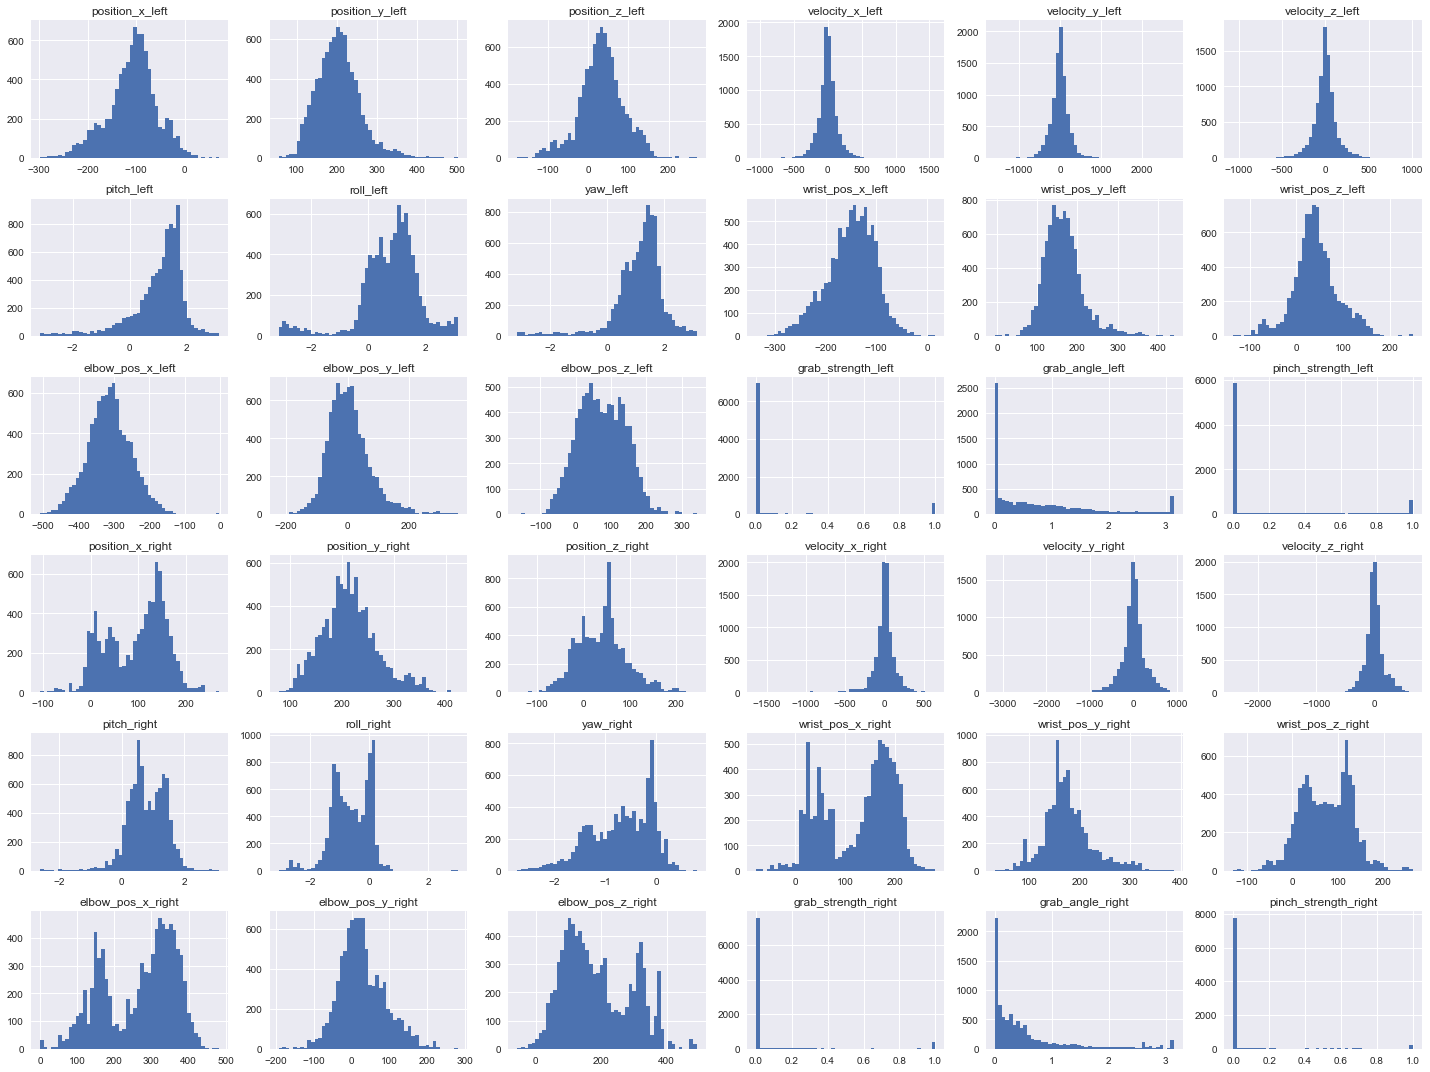

In [69]:
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

In [70]:
state_groups = hands.drop("time", axis=1, inplace=False).groupby("state")

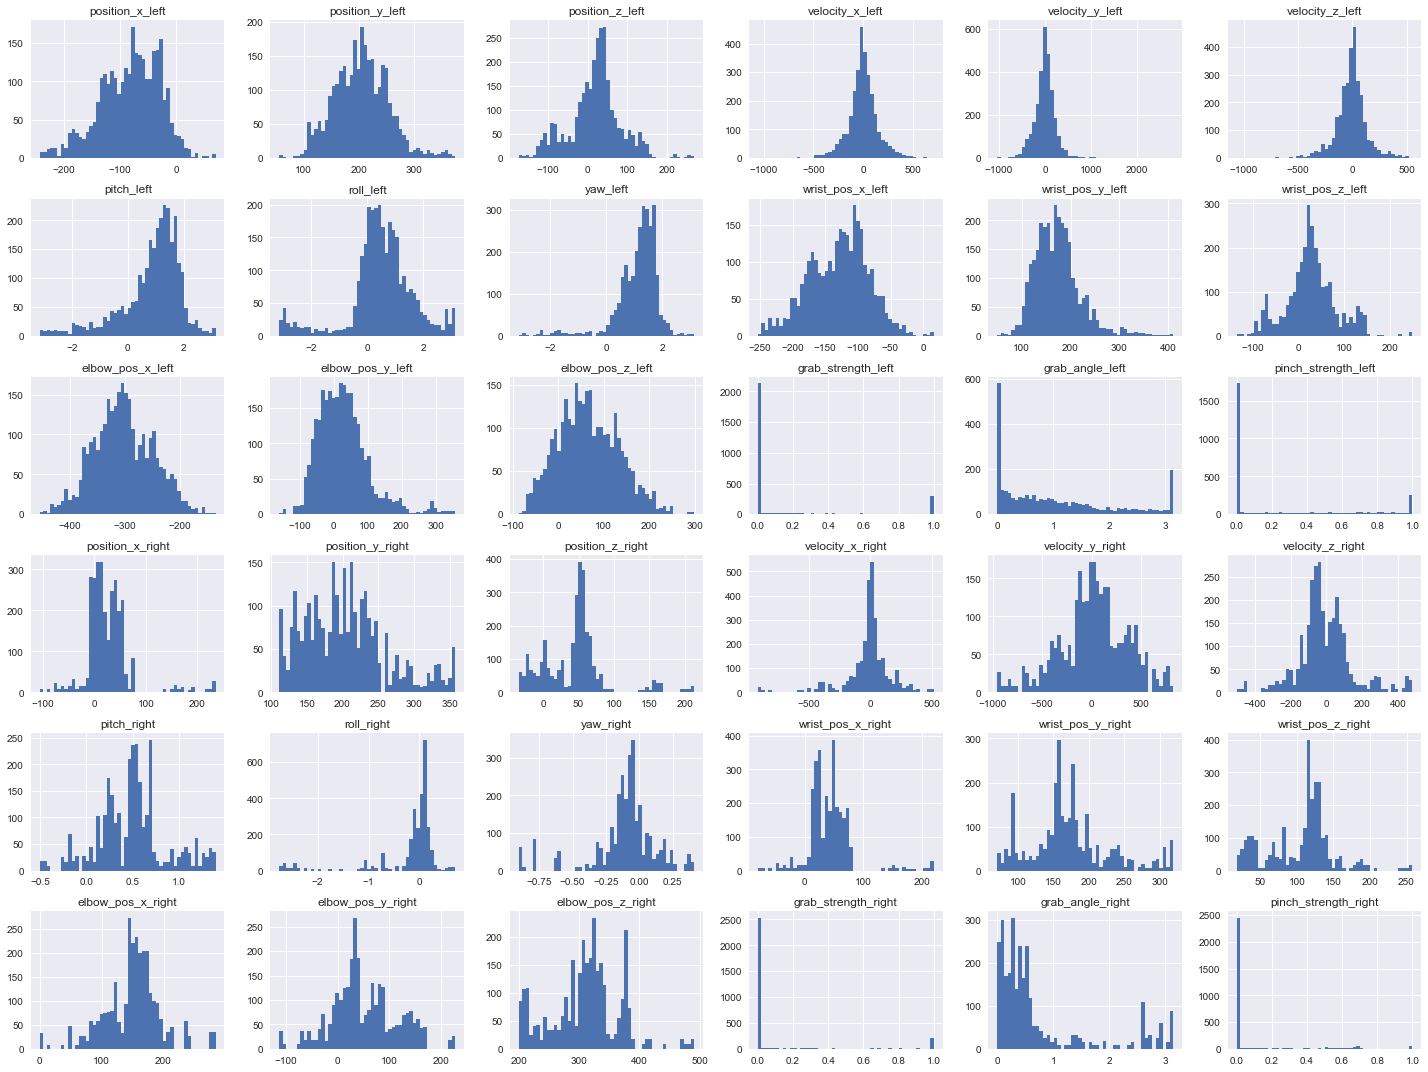

In [33]:
state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

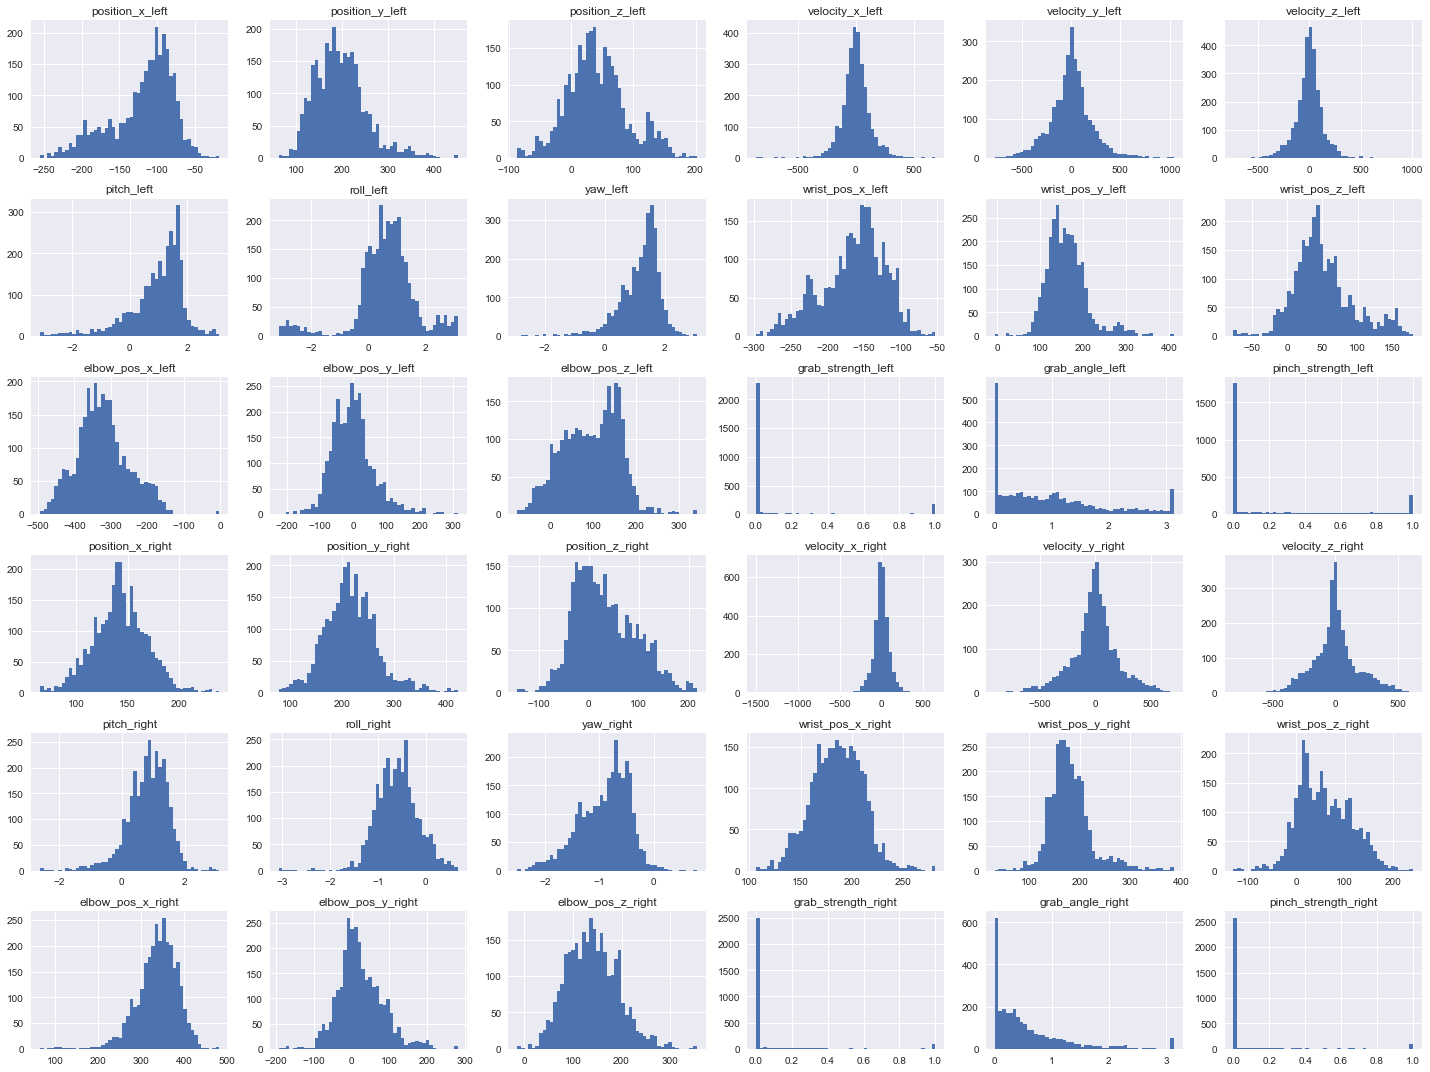

In [34]:
state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

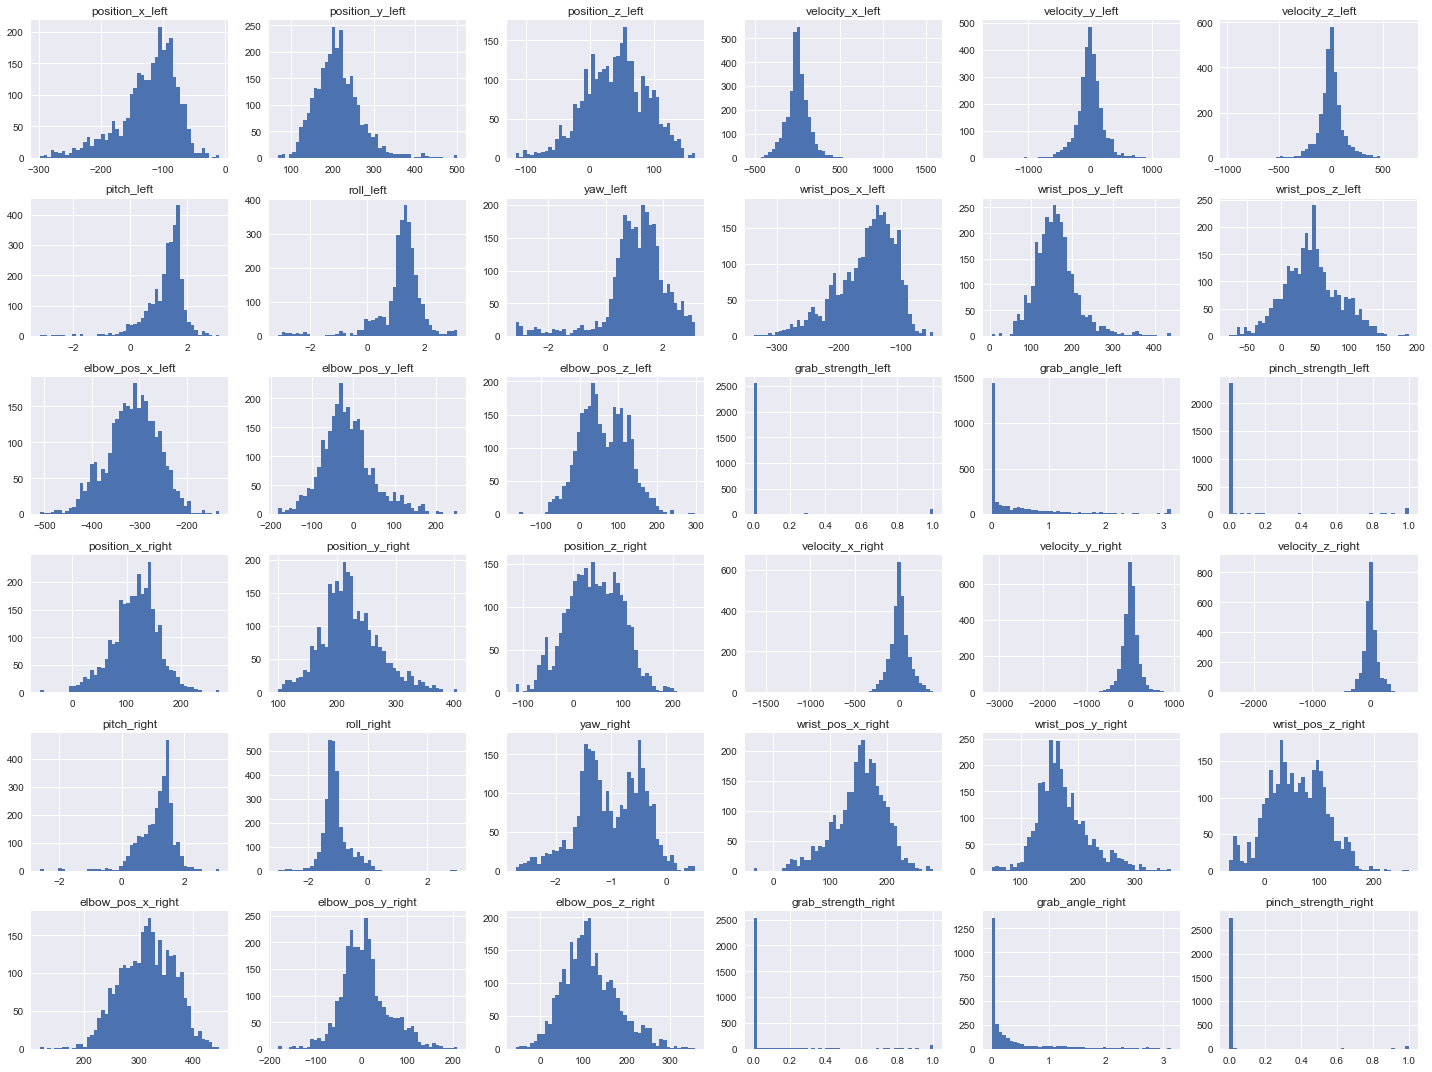

In [35]:
state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

In [36]:
attributes = {"grab_strength_left", "grab_angle_left", "grab_strength_right", "grab_angle_right"}
hands.drop("time", axis=1, inplace=False).groupby("state").agg(["mean", "std", "min", "max"])[attributes]

grab_strength_right                     grab_angle_right                 \
                     mean       std  min  max             mean       std  min   
state                                                                           
0                0.090758  0.269484  0.0  1.0         0.745256  0.888241  0.0   
1                0.067197  0.211485  0.0  1.0         0.564080  0.646416  0.0   
2                0.071968  0.222111  0.0  1.0         0.383599  0.634208  0.0   

                grab_strength_left                     grab_angle_left  \
            max               mean       std  min  max            mean   
state                                                                    
0      3.141593           0.170635  0.337942  0.0  1.0        1.020889   
1      3.141593           0.122482  0.286733  0.0  1.0        0.963352   
2      3.141593           0.072375  0.227101  0.0  1.0        0.485455   

                                
            std  min       max  
state                           
0      0.988558  0.0  3.141593  
1      0.893758  0.0  3.141593  
2      0.766741  0.0  3.141593

In [85]:
# hands["pinch_strength_right"].unique()

In [38]:
hands.groupby("state").get_group(0)

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
706,0,525.8185,-52.96039,184.5535,-2.856696,162.15270,127.60520,-85.837820,1.238877,1.021919,1.199751,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,11.930320,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.457400,206.0521,45.38764,284.3946,140.01670,201.9318,0.0,0.561324,0.0
707,0,525.8351,-50.04434,185.5024,-4.845364,102.82480,-24.84337,-79.465040,1.244299,1.132981,1.171960,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,11.191900,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.461410,202.4562,44.28679,282.6278,140.97120,203.6773,0.0,0.626321,0.0
708,0,525.8516,-49.07749,182.2930,-6.442950,12.12360,-258.75260,-99.409020,1.220772,1.250050,1.152816,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,10.533080,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.600600,197.4387,43.54082,280.6384,142.54010,206.7526,0.0,0.636596,0.0
709,0,525.8682,-50.89614,176.7708,-9.005262,-53.57292,-271.01500,-143.033300,1.096965,1.535388,1.114818,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,10.243000,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.195370,191.7202,42.73155,279.7357,148.13820,209.9330,0.0,0.701644,0.0
710,0,525.8848,-51.76074,174.1853,-10.600340,-40.95883,-140.44390,-59.856200,1.004597,1.760037,1.091361,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,10.020610,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.686710,186.1613,41.98006,278.6890,152.52150,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8602,0,763.7918,-106.61790,205.8969,22.956170,-24.61669,23.16306,93.724650,1.023968,1.251673,0.662165,-139.29900,145.0874,48.891030,-274.2361,-66.639630,120.200100,0.0,0.000000,0.0,-2.810754,201.7718,158.320900,-169.933900,505.3127,46.38729,1.272993,-0.075408,-0.201355,14.562450,132.1908,186.47680,151.1258,-70.92343,307.1459,0.0,0.550510,0.0
8603,0,763.8262,-110.68560,209.6540,28.026860,-110.53730,89.03648,118.772600,1.061072,1.298741,0.621035,-140.13100,146.5178,52.220710,-268.2674,-72.216730,114.330300,0.0,0.000000,0.0,-5.496830,210.8190,159.534000,-131.583800,534.0756,55.61877,1.321800,-0.071947,-0.291834,13.112300,140.5591,184.95940,156.6065,-54.20612,311.2205,0.0,0.657268,0.0
8604,0,763.8588,-114.36590,213.2949,31.358430,-114.39520,112.02060,108.559000,1.091780,1.316953,0.604451,-142.09930,148.8385,54.030390,-267.3777,-72.560460,112.418600,0.0,0.000000,0.0,-8.173754,219.3508,159.460600,-158.067400,456.0570,-31.19657,1.364439,-0.105565,-0.381360,11.122230,148.3210,182.01700,157.6199,-46.78390,304.2402,0.0,0.725948,0.0
8605,0,763.8915,-117.04390,216.8946,33.815000,-77.28199,125.23520,68.083810,1.122401,1.336131,0.581930,-143.03230,151.1616,54.810170,-267.6999,-72.318370,106.152600,0.0,0.000000,0.0,-10.273160,225.8339,157.148800,-106.639700,401.9494,-127.14530,1.381479,-0.065906,-0.437379,9.360494,154.3557,178.04090,156.6281,-48.72800,285.4431,0.0,0.585126,0.0


### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

In [216]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [217]:
trainX, valX = split_train_val(load_data(train_path, as_pandas=False))


training_data = []

# glob searches all directories and files
for filename in glob.iglob("extraFiles/Training/**/*.csv", recursive=True):
    df = pd.read_csv(filename, index_col=None, header=0)
    remove_first7(df) # removes first 7 seconds from file
    if "Alone" in filename:
        df = combine_right(df, False)
        df.insert(0, "state", 0)
    elif "Sync" in filename:
        df.insert(0, "state", 1)
    elif "Spontan" in filename:
        df.insert(0, "state", 2)
    df = transform_columns(df)
    training_data.append(df)

# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns2(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    return left.merge(right, how="outer", on=["state", "time"])

# function combines alone csv file with the right hand file

def combine_right2(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    if len(right) > len(df_alone):
        right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0
    else:
        df_alone = df_alone.loc[:len(right)-1]
    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

alone["Time"] = alone["Time"] - alone["Time"].min()

    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index() # first four instances per second

In [140]:
# adds a column with the second
new.insert(1, "round_time", new.time.astype(int) - new.time.min().astype(int))

ValueError: cannot insert round_time, already exists

In [ ]:
new

In [ ]:
# round time is the index after groupby
merged = new.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True)

In [ ]:
merged.head(10)

In [ ]:
merged.isna().sum()

In [ ]:
merged

In [218]:
from sklearn.neighbors import KNeighborsClassifier

X_train = trainX.drop("state", axis=1)
y_train = trainX.state.copy()
X_val = valX.drop("state", axis=1)
y_val = valX.state.copy()

In [219]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
pred = knn.predict(X_val)

In [221]:
from sklearn import metrics

In [222]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       0.89      0.81      0.85       230
           2       0.83      0.90      0.86       230

    accuracy                           0.90       686
   macro avg       0.90      0.90      0.90       686
weighted avg       0.90      0.90      0.90       686

